In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#importing our package
from Bayesian_hmm import *

In [2]:
from os import listdir
from sklearn.metrics import confusion_matrix

In [3]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=2)

### Simulated data


In [4]:
#Class 1 
n_c1 = 60
P1 = generate_transtion_matrix(3) #random transition matrix with 3 states
params1 = {0: [2, 2], 1 : [3, 1], 2: [1, 1]} #state : [mu, sigma]
len_range1 = [50, 100]
Y1 = generate_samples(n_c1, len_range1, P1, params1, noise=0.1)

In [5]:
#class 2
n_c2 = 65
P2 = generate_transtion_matrix(3) #random transition matrix with 3 states
params2 = {0: [3, 2], 1 : [3, 2], 2: [1, 2]} #state : [mu, sigma]
len_range2 = [50, 100]
Y2 = generate_samples(n_c2, len_range2, P2, params2, noise=0.1)

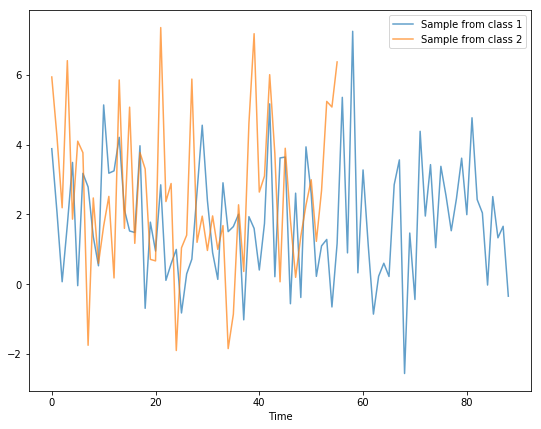

In [6]:
plt.figure(figsize=(9, 7))
plt.plot(Y1[0], label="Sample from class 1", alpha=0.7)
plt.plot(Y2[0], label="Sample from class 2", alpha=0.7)
plt.legend(loc='best')
plt.xlabel("Time")
plt.show()

In [7]:
#Class 1 
prior_transition1 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params1 = {0: [0, 1, 1, 2],
                1: [0, 1, 1, 2],
                2: [0, 1, 1, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 20000 #number of iteration in gibbs sampling method to estimate parameters.

In [8]:
model_class1 = bayesian_hmm(prior_params1, prior_transition1, n_iter_gibbs, class_label=1)
%time model_class1.fit([np.concatenate(Y1[:-14])])

Model fitted
Wall time: 1.62 s


In [10]:
#Class 2
prior_transition2 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params2 = {0: [0, 1, 1, 2],
                1: [0, 1, 1, 2],
                2: [0, 1, 1, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 20000 #number of iteration in gibbs sampling method to estimate parameters.

In [11]:
model_class2 = bayesian_hmm(prior_params2, prior_transition2, n_iter_gibbs, class_label=2)
%time model_class2.fit([np.concatenate(Y2[:-15])])

Model fitted
Wall time: 1.58 s


In [12]:
model_class2.posterior_params

{0: [2.1034279304506303, 2.1824504000707305, 1, 2],
 1: [2.4417848861987523, 2.2157708597383077, 1, 2],
 2: [3.3722168523368676, 2.213365127560079, 1, 2]}

In [13]:
X_test = Y1[-14:]+Y2[-15:]
y_test = np.array([1]*len(Y1[-14:]) + [2]*len(Y2[-15:]))

In [14]:
preds = assign_classes(X_test, [model_class1, model_class2])

In [15]:
np.sum(preds == y_test) / len(preds)

0.8275862068965517

In [16]:
confusion_matrix(y_test, preds)

array([[14,  0],
       [ 5, 10]], dtype=int64)

In [17]:
# To use knn classifier, series must be truncated to ensure same length
X_test_trunc = [list(e)[:50] for e in X_test]
X_train = Y1[:-14]+Y2[:-15]
X_train_trunc = [list(e)[:50] for e in X_train]
y_train = [1] * len(Y1[:-14]) + [2] * len(Y2[:-15])

In [18]:
clf.fit(X_train_trunc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [19]:
clf.score(X_test_trunc, y_test)

0.5517241379310345

In [20]:
clf.score(X_train_trunc, y_train)

0.6354166666666666

#### Motion data

In [21]:
# return list of traces, and arrays for targets, groups and paths
def load_dataset(prefix='motion/'):
    grps_dir, data_dir = prefix+'groups/', prefix+'dataset/'
    # load mapping files
    targets = pd.read_csv(data_dir + 'MovementAAL_target.csv', header=0)
    groups = pd.read_csv(grps_dir + 'MovementAAL_DatasetGroup.csv', header=0)
    paths = pd.read_csv(grps_dir + 'MovementAAL_Paths.csv', header=0)
    sequences = list()
    target_mapping = None
    for name in listdir(data_dir):
        filename = data_dir + name
        if filename.endswith('_target.csv'):
            continue
        df = pd.read_csv(filename, header=0)
        values = df.values
        sequences.append(values)
    return sequences, targets.values[:,1], groups.values[:,1], paths.values[:,1]
 
# load dataset
sequences, targets, groups, paths = load_dataset()
# summarize shape of the loaded data
print(len(sequences), targets.shape, groups.shape, paths.shape)

314 (314,) (314,) (314,)


In [22]:
# summarize class breakdown
class1,class2 = len(targets[targets==-1]), len(targets[targets==1])
print('Class=-1: %d %.3f%%' % (class1, class1/len(targets)*100))
print('Class=+1: %d %.3f%%' % (class2, class2/len(targets)*100))

Class=-1: 156 49.682%
Class=+1: 158 50.318%


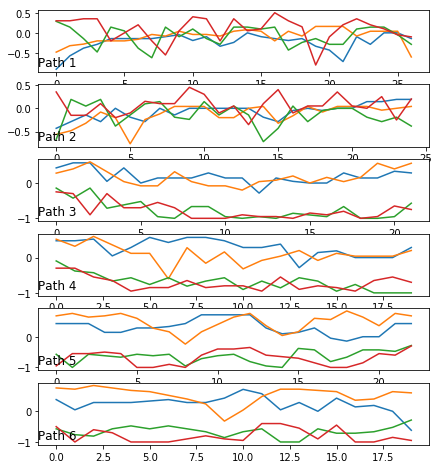

In [6]:
paths = [1,2,3,4,5,6]
seq_paths = dict()
for path in paths:
    seq_paths[path] = [sequences[j] for j in range(len(paths)) if paths[j]==path]
# plot one example of a trace for each path
plt.figure(figsize=(7,8))
for i in paths:
    plt.subplot(len(paths), 1, i)
    # line plot each variable
    for j in [0, 1, 2, 3]:
        plt.plot(seq_paths[i][0][:, j], label='Anchor ' + str(j+1))
    plt.title('Path ' + str(i), y=0, loc='left')
plt.show()

In [7]:
# create a fixed 1d vector for each trace with output variable
def create_dataset(sequences, targets):
    # create the transformed dataset
    transformed = list()
    n_vars = 4
    n_steps = 19
    # process each trace in turn
    for i in range(len(sequences)):
        seq = sequences[i]
        vector = list()
        # last n observations
        for row in range(1, n_steps+1):
            for col in range(n_vars):
                vector.append(seq[-row, col])
        # add output
        vector.append(targets[i])
        # store
        transformed.append(vector)
    # prepare array
    transformed = np.array(transformed)
    transformed = transformed.astype('float32')
    return transformed

In [8]:
seq1 = [sequences[i] for i in range(len(groups)) if groups[i]==1]
seq2 = [sequences[i] for i in range(len(groups)) if groups[i]==2]
seq3 = [sequences[i] for i in range(len(groups)) if groups[i]==3]
# separate target
targets1 = [targets[i] for i in range(len(groups)) if groups[i]==1]
targets2 = [targets[i] for i in range(len(groups)) if groups[i]==2]
targets3 = [targets[i] for i in range(len(groups)) if groups[i]==3]

In [9]:
es2_train = create_dataset(seq1+seq2, targets1+targets2)
es2_test = create_dataset(seq3, targets3)

In [10]:
X_train, y_train = es2_train[:, :-1], es2_train[:, -1]
X_test, y_test = es2_test[:, :-1], es2_test[:, -1]

In [77]:
X, y = list(X_train) + list(X_test), list(y_train) + list(y_test)

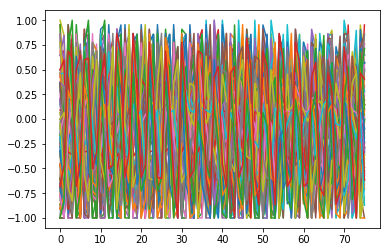

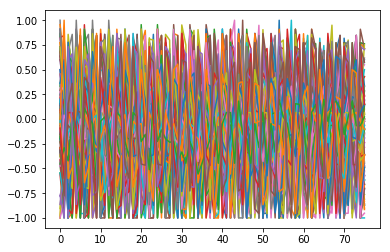

In [11]:
X1_train = []
X2_train = []
for i in range(len(X_train)):
    if y_train[i] == 1:
        X1_train.append(X_train[i])
        plt.plot(X_train[i])
plt.show()
for i in range(len(X_train)):
    if y_train[i] == -1:
        X2_train.append(X_train[i])
        plt.plot(X_train[i])

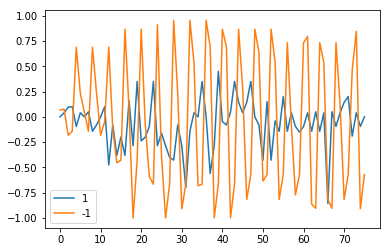

In [56]:
plt.plot(X1_train[12], label='1')
plt.plot(X2_train[5], label='-1')
plt.legend()

In [64]:
#Class 1 
prior_transition1 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params1 = {0: [0, 1, 2, 2],
                1: [0, 1, 2, 2],
                2: [0, 1, 2, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 20000 #number of iteration in gibbs sampling method to estimate parameters.

In [65]:
model_class1 = bayesian_hmm(prior_params1, prior_transition1, n_iter_gibbs, class_label=1)
%time model_class1.fit([np.concatenate(X1_train)])

Model fitted
Wall time: 1.6 s


In [66]:
model_class1.posterior_params

{0: [-0.09371613979569837, 0.5263574145523395, 2, 2],
 1: [-0.20785181809935369, 0.538178719607866, 2, 2],
 2: [-0.14620339131480573, 0.505231788426691, 2, 2]}

In [67]:
#Class 1 
prior_transition2 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params2 = {0: [0, 2, 2, 2],
                1: [0, 2, 2, 2],
                2: [0, 2, 2, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 20000 #number of iteration in gibbs sampling method to estimate parameters.

In [68]:
model_class2 = bayesian_hmm(prior_params2, prior_transition2, n_iter_gibbs, class_label=-1)
%time model_class2.fit([np.concatenate(X2_train)])

Model fitted
Wall time: 1.66 s


In [69]:
model_class2.posterior_params

{0: [0.024718021831350533, 0.5203119019348841, 2, 2],
 1: [-0.20346651349145933, 0.5205356238757056, 2, 2],
 2: [-0.19855046735153326, 0.5106683599085214, 2, 2]}

In [70]:
preds = assign_classes(X_test, [model_class1, model_class2], verbose=True)

-----
Assigning class to series
-----
[(-125.03119717165042, 1), (-117.98256521874279, -1)]
----
[(-110.6087901198783, 1), (-106.37764625075374, -1)]
----
[(-123.64023635365014, 1), (-117.31461864777862, -1)]
----
[(-122.23746234164919, 1), (-116.37426786082483, -1)]
----
[(-125.04171591689953, 1), (-118.32386251617058, -1)]
----
[(-123.37105156501333, 1), (-116.53821315530783, -1)]
----
[(-121.48760256061792, 1), (-114.95160814649547, -1)]
----
[(-114.83480835299974, 1), (-109.52669241547265, -1)]
----
[(-113.26594525667001, 1), (-108.40535189766373, -1)]
----
[(-107.92122137804698, 1), (-104.01070970190018, -1)]
----
[(-105.63673619716273, 1), (-102.06663241351927, -1)]
----
[(-104.68752461315317, 1), (-101.21343397774518, -1)]
----
[(-122.27331743339056, 1), (-115.86886707805134, -1)]
----
[(-112.7969609170508, 1), (-108.6562268237421, -1)]
----
[(-125.4232754260234, 1), (-118.4283093083844, -1)]
----
[(-124.96749732891485, 1), (-118.21745382350596, -1)]
----
[(-108.40603866744782, 

In [71]:
confusion_matrix(y_test, preds)

array([[50,  0],
       [54,  0]], dtype=int64)

In [73]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [75]:
clf.score(X_test, y_test)

0.5

In [81]:
from sklearn.model_selection import train_test_split
import time

In [82]:
def evaluate_hmm(X, y, n_split):
    acc = []
    for k in range(n_split):
        s = time.time()
        X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.33)
        X1_train = []
        X2_train = []
        for i in range(len(X_train)):
            if y_train[i] == 1:
                X1_train.append(X_train[i])
        for i in range(len(X_train)):
            if y_train[i] == -1:
                X2_train.append(X_train[i])
        prior_transition = np.ones((3, 3)) 
        prior_params = {0: [0, 1, 2, 2],
                        1: [0, 1, 2, 2],
                        2: [0, 1, 2, 2]} 
        n_iter_gibbs = 20000
        model_class1 = bayesian_hmm(prior_params, prior_transition, n_iter_gibbs, class_label=1)
        model_class1.fit([np.concatenate(X1_train)])
        model_class2 = bayesian_hmm(prior_params, prior_transition, n_iter_gibbs, class_label=-1)
        model_class2.fit([np.concatenate(X2_train)])
        preds = assign_classes(X_test, [model_class1, model_class2])
        acc.append(np.sum(y_test == preds) / len(preds))
        print("Timeit:", round(time.time() - s, 2))
        print("----")
    return acc

In [84]:
accs = evaluate_hmm(X, y, 30)

Model fitted
Model fitted
Timeit: 6.23
----
Model fitted
Model fitted
Timeit: 6.26
----
Model fitted
Model fitted
Timeit: 6.21
----
Model fitted
Model fitted
Timeit: 6.28
----
Model fitted
Model fitted
Timeit: 6.59
----
Model fitted
Model fitted
Timeit: 6.66
----
Model fitted
Model fitted
Timeit: 6.23
----
Model fitted
Model fitted
Timeit: 6.51
----
Model fitted
Model fitted
Timeit: 6.35
----
Model fitted
Model fitted
Timeit: 6.36
----
Model fitted
Model fitted
Timeit: 6.34
----
Model fitted
Model fitted
Timeit: 6.33
----
Model fitted
Model fitted
Timeit: 6.46
----
Model fitted
Model fitted
Timeit: 6.41
----
Model fitted
Model fitted
Timeit: 6.32
----
Model fitted
Model fitted
Timeit: 6.29
----
Model fitted
Model fitted
Timeit: 6.28
----
Model fitted
Model fitted
Timeit: 6.38
----
Model fitted
Model fitted
Timeit: 6.31
----
Model fitted
Model fitted
Timeit: 6.23
----
Model fitted
Model fitted
Timeit: 6.23
----
Model fitted
Model fitted
Timeit: 6.35
----
Model fitted
Model fitted
Timeit

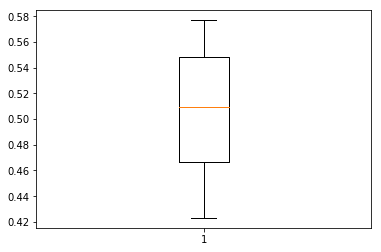

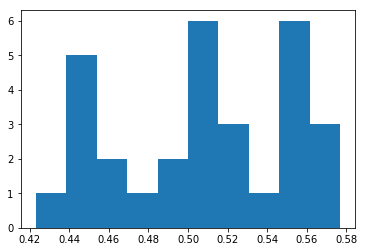

In [88]:
plt.boxplot(accs)
plt.show()
plt.hist(accs)
plt.show()

In [89]:
np.mean(accs)

0.5067307692307692